## Comparing RDD with DataFrame for Data Processing

**1.1 Data Loading**

In [1]:
# Reference taken from lab
# Import SparkConf class into program
from pyspark import SparkConf
# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# local[*]: run Spark in local mode with as many working processors as logical cores on my machine
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Comparing RDD with DataFrame"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "Australia/Melbourne")
print(spark_conf.toDebugString())

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

spark.master=local[*]
spark.app.name=Assignment 1
spark.sql.session.timeZone=Australia/Melbourne


2. Read pedestrian count CSV file into a single RDD; and read the sensor location CSV file into another RDD  

In [2]:
# import required modules
from datetime import datetime
from pyspark.sql import Row

# function that reads the csv file, remove the header and split the rdd by comma
def readCsvFileGetRddAndHeader(csv_file):
    # read the csv file
    rdd = sc.textFile(csv_file)
    # removing header
    header = rdd.first()
    rdd = rdd.filter(lambda x:x!=header)
    # split header
    header_split = header.split(",")
    # split the rdd to be returned
    rdd = rdd.map(lambda x:x.split(','))
    return rdd, header_split

### For Pedestrian Count
p_monthly_counts_rdd, monthly_counts_header_split = readCsvFileGetRddAndHeader("Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv")
# creating a new type of row
Monthly_Count_Row = Row(monthly_counts_header_split[0], monthly_counts_header_split[1],monthly_counts_header_split[2], monthly_counts_header_split[3],monthly_counts_header_split[4], monthly_counts_header_split[5],monthly_counts_header_split[6], monthly_counts_header_split[7],monthly_counts_header_split[8],monthly_counts_header_split[9])
# changing each column to the apprioprate data type
p_monthly_counts_rdd = p_monthly_counts_rdd.map(lambda x:[int(x[0]),datetime.strptime(x[1], '%m/%d/%Y %I:%M:%S %p'), int(x[2]), x[3],int(x[4]), x[5],int(x[6]), int(x[7]), x[8],int(x[9])])
# putting into Rows
rows_p_monthly_counts_rdd = p_monthly_counts_rdd.map(lambda x:Monthly_Count_Row(x[0],x[1],x[2],x[3],x[4],x[5],x[6], x[7], x[8], x[9]))


### For Sensor Locations
sensor_rdd, sensor_header_split = readCsvFileGetRddAndHeader("Pedestrian_Counting_System_-_Sensor_Locations.csv")
# creating a new type of row
Sensor_Row = Row(sensor_header_split[0], sensor_header_split[1],sensor_header_split[2], sensor_header_split[3],sensor_header_split[4], sensor_header_split[5],sensor_header_split[6], sensor_header_split[7],sensor_header_split[8],sensor_header_split[9],sensor_header_split[10])
# changing each column to the apprioprate data type
sensor_rdd = sensor_rdd.map(lambda x: [int(x[0]), x[1], x[2], datetime.strptime(x[3], '%Y/%m/%d').date(), x[4], x[5], x[6], x[7], float(x[8]), float(x[9]), (float(x[8]), float(x[9]))])
# putting into Rows
rows_sensor_rdd = sensor_rdd.map(lambda x:Sensor_Row(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10]))

3. For each RDD, display the number of columns, the total number of records, and display the first 2 records

In [3]:
# function to print the details of a RDD
def printDetails(string_description, rdd, row_rdd):
    print(string_description)
    print("--------------------------------")
    print("Number of columns: "+str(len(rdd.take(1)[0])))
    print("Number of rows: "+str(rdd.count()))
    print("--------------------------------")
    print("Sample data (first 2 records)")
    first_two_count_rows = row_rdd.take(2)
    print(first_two_count_rows[0])
    print(first_two_count_rows[1])

# print for pedestrian count
printDetails("For pedestrian count data file: ", p_monthly_counts_rdd, rows_p_monthly_counts_rdd)
print("\n-----------------------------------------------------------------\n")
# print for sensor location
printDetails("For sensor location data file: ", sensor_rdd, rows_sensor_rdd)

For pedestrian count data file: 
--------------------------------
Number of columns: 10
Number of rows: 3435106
--------------------------------
Sample data (first 2 records)
Row(ID=2887628, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=34, Sensor_Name='Flinders St-Spark La', Hourly_Counts=300)
Row(ID=2887629, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=39, Sensor_Name='Alfred Place', Hourly_Counts=604)

-----------------------------------------------------------------

For sensor location data file: 
--------------------------------
Number of columns: 11
Number of rows: 72
--------------------------------
Sample data (first 2 records)
Row(sensor_id=59, sensor_description='Building 80 RMIT', sensor_name='RMIT_T', installation_date=datetime.date(2019, 2, 13), status='A', note='', direction_1='North', direction_2='South', latitude=-37.80825

## 1.2 Analysis  

In [4]:
# create a rdd with key,pair of Hourly_Counts, ID for range partitioning
p_monthly_counts_rdd_2_col = rows_p_monthly_counts_rdd.map(lambda x:(x[9], x[0]))

# define the range and range function
no_of_partitions = 16
range_arr=[[0,999],[1000,1999],[2000,2999],[3000,3999],[4000,4999],[5000,5999],[6000,6999],[7000,7999],[8000,8999],[9000,9999],[10000,10999],[11000,11999],[12000,12999],[13000,13999],[14000,14999],[15000,15999]]

def range_function(key):
    for index,item in enumerate(range_arr):
        if key >=item[0] and key <=item[1]:
            return index

# partition the rdd using the range funtions
range_partitioned_rdd = p_monthly_counts_rdd_2_col.partitionBy(no_of_partitions, range_function)

# print out the number of partitions and the number of records per partition
print(f"####### NUMBER OF PARTITIONS: "+str(range_partitioned_rdd.getNumPartitions()))
partitions = range_partitioned_rdd.glom().collect()
for index, partition in enumerate(partitions):
    print(f"Partition {range_arr[index][0]} - {range_arr[index][1]}: {len(partition)} records")

####### NUMBER OF PARTITIONS: 16
Partition 0 - 999: 2795353 records
Partition 1000 - 1999: 388811 records
Partition 2000 - 2999: 168802 records
Partition 3000 - 3999: 61993 records
Partition 4000 - 4999: 15829 records
Partition 5000 - 5999: 3779 records
Partition 6000 - 6999: 337 records
Partition 7000 - 7999: 110 records
Partition 8000 - 8999: 44 records
Partition 9000 - 9999: 29 records
Partition 10000 - 10999: 8 records
Partition 11000 - 11999: 8 records
Partition 12000 - 12999: 1 records
Partition 13000 - 13999: 0 records
Partition 14000 - 14999: 1 records
Partition 15000 - 15999: 1 records


Trend from 2009 till 2020 in terms of the yearly total pedestrian counts and the average daily pedestrian counts

In [5]:
#extract just the hourly counts and year into a rdd
year_and_counts_rdd = rows_p_monthly_counts_rdd.map(lambda x:(x[2], x[9]))

# reduce by key(year) so that each year will have the sum of all the hourly counts
year_and_total_counts_rdd = year_and_counts_rdd.reduceByKey(lambda x,y : x+y)

# sort by the key which is year in ascending order
year_and_total_counts_list = year_and_total_counts_rdd.sortByKey().collect()

# print out the results
for year_and_total_counts in year_and_total_counts_list:
    print("Year "+str(year_and_total_counts[0])+" \t Total Pedestrian Count: "+str(year_and_total_counts[1])+" \t Average Daily Pedestrian Count: "+str(round(year_and_total_counts[1]/365,2)))

Year 2009 	 Total Pedestrian Count: 62650110 	 Average Daily Pedestrian Count: 171644.14
Year 2010 	 Total Pedestrian Count: 93459437 	 Average Daily Pedestrian Count: 256053.25
Year 2011 	 Total Pedestrian Count: 90571965 	 Average Daily Pedestrian Count: 248142.37
Year 2012 	 Total Pedestrian Count: 102215521 	 Average Daily Pedestrian Count: 280042.52
Year 2013 	 Total Pedestrian Count: 117389820 	 Average Daily Pedestrian Count: 321615.95
Year 2014 	 Total Pedestrian Count: 169500386 	 Average Daily Pedestrian Count: 464384.62
Year 2015 	 Total Pedestrian Count: 209099687 	 Average Daily Pedestrian Count: 572875.85
Year 2016 	 Total Pedestrian Count: 228757880 	 Average Daily Pedestrian Count: 626733.92
Year 2017 	 Total Pedestrian Count: 216586414 	 Average Daily Pedestrian Count: 593387.44
Year 2018 	 Total Pedestrian Count: 261909318 	 Average Daily Pedestrian Count: 717559.78
Year 2019 	 Total Pedestrian Count: 266411675 	 Average Daily Pedestrian Count: 729895.0
Year 2020 	 To

Calculating the average hourly pedestrian count for each sensor, and sort the average count from highest to lowest. 

In [6]:
# get a rdd which contains just the sensor ID and hourly counts
rows_sensorid_hourly_count_rdd = rows_p_monthly_counts_rdd.map(lambda x:[x[7], x[9]])
rows_sensorid_hourly_count_rdd.take(5)

# get a rdd which contains sensor ID and sensor description 
rows_sensorid_sensor_desc_rdd = rows_sensor_rdd.map(lambda x:[x[0],x[1]])
rows_sensorid_sensor_desc_rdd.take(5)

# reduce by the sensor id key
sensor_id_and_total_ped_count_list = rows_sensorid_hourly_count_rdd.reduceByKey(lambda x,y : x+y)

# join the rdds
joined_sensor_rdd_list = sensor_id_and_total_ped_count_list.join(rows_sensorid_sensor_desc_rdd).collect()

# get the average hourly counts 
joined_sensor_rdd_list_2 = []
for joined_sensor_rdd in joined_sensor_rdd_list:
    sensor_id = joined_sensor_rdd[0]
    average_hourly_count = round( (joined_sensor_rdd[1][0] / 24), 2)
    sensor_desc = joined_sensor_rdd[1][1]
    joined_sensor_rdd_list_2.append([sensor_id, average_hourly_count, sensor_desc])

# sort by key in descending order
joined_sensor_rdd_list_2.sort(key = lambda x:x[1], reverse = True)   

# display the top 5
for i in range(5):
    sensor_id = str(joined_sensor_rdd_list_2[i][0])
    average_hourly_count = str(joined_sensor_rdd_list_2[i][1])
    sensor_desc = joined_sensor_rdd_list_2[i][2]
    
    print("Sensor ID "+sensor_id+"\t Sensor description: "+sensor_desc+"\t Average hourly count: "+average_hourly_count)

Sensor ID 4	 Sensor description: Town Hall (West)	 Average hourly count: 5642652.54
Sensor ID 6	 Sensor description: Flinders Street Station Underpass	 Average hourly count: 4823159.08
Sensor ID 3	 Sensor description: Melbourne Central	 Average hourly count: 4674128.29
Sensor ID 2	 Sensor description: Bourke Street Mall (South)	 Average hourly count: 4348132.83
Sensor ID 5	 Sensor description: Princes Bridge	 Average hourly count: 4252023.88


## 2. Working with DataFrames
**2.1 Data Loading**

In [7]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType

# defining the Monthly counts data schema
montly_counts_schema = StructType([StructField("ID",IntegerType(),False), 
                                   StructField("Date_Time", StringType(),True), 
                                   StructField("Year", IntegerType(),True), 
                                   StructField("Month", StringType(),True), 
                                   StructField("Mdate", IntegerType(),True), 
                                   StructField("Day", StringType(),True), 
                                   StructField("Time", IntegerType(),True),
                                   StructField("Sensor_ID", IntegerType(),True),
                                   StructField("Sensor_Name", StringType(),True),
                                   StructField("Hourly_Counts", IntegerType(),True)])

# defining the Sensor data schema
sensor_schema = StructType([StructField("sensor_id",IntegerType(),False), 
                            StructField("sensor_description",StringType(),False), 
                            StructField("sensor_name",StringType(),False), 
                            StructField("installation_date",StringType(),False), 
                            StructField("status",StringType(),False), 
                            StructField("note",StringType(),False), 
                            StructField("direction_1",StringType(),False), 
                            StructField("direction_2",StringType(),False), 
                            StructField("latitude",FloatType(),False), 
                            StructField("longitude",FloatType(),False), 
                            StructField("location",StringType(),False)])

In [8]:
# function to read csv into df with a given schema
def readCsvToDf(filename:str, schema):
    df = spark.read.format("csv").option("header", "true").schema(schema).load(filename)
    df.printSchema()
    return df

# load pedestrian count and sensor location CSV file into a dataframe
monthly_counts_df = readCsvToDf("Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv", montly_counts_schema)
sensors_df = readCsvToDf("Pedestrian_Counting_System_-_Sensor_Locations.csv", sensor_schema)

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: string (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType, DateType, ArrayType

# showing record 2853222 and 2853223 before conversion
print("Before conversion: ")
monthly_counts_df.filter(monthly_counts_df["ID"] == 2853222).show()
monthly_counts_df.filter(monthly_counts_df["ID"] == 2853223).show()

# convert Date_Time into date-time
monthly_counts_df = monthly_counts_df.withColumn("Date_Time",to_timestamp(col("Date_Time"), "MM/dd/yyyy hh:mm:ss a").alias("Date_Time"))
monthly_counts_df = monthly_counts_df.withColumn("Date_Time",col("Date_Time").cast(TimestampType()))
# monthly_counts_df.show()

# showing record 2853222 and 2853223 after conversion
print("After conversion: ")
monthly_counts_df.filter(monthly_counts_df["ID"] == 2853222).show()
monthly_counts_df.filter(monthly_counts_df["ID"] == 2853223).show()

# change the column types 
sensors_df = sensors_df.withColumn("installation_date",to_date(col("installation_date"), "yyyy/MM/dd").alias("installation_date"))
sensors_df = sensors_df.withColumn("installation_date",col("installation_date").cast(DateType()))
sensors_df = sensors_df.withColumn("location", array(sensors_df["latitude"], sensors_df["longitude"]) )
# sensors_df.show()

# print schemas
monthly_counts_df.printSchema()
sensors_df.printSchema()

Before conversion: 
+-------+--------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|     ID|           Date_Time|Year|  Month|Mdate|   Day|Time|Sensor_ID|        Sensor_Name|Hourly_Counts|
+-------+--------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|2853222|10/06/2019 02:00:...|2019|October|    6|Sunday|   2|       62|La Trobe St (North)|            0|
+-------+--------------------+----+-------+-----+------+----+---------+-------------------+-------------+

+-------+--------------------+----+-------+-----+------+----+---------+----------------+-------------+
|     ID|           Date_Time|Year|  Month|Mdate|   Day|Time|Sensor_ID|     Sensor_Name|Hourly_Counts|
+-------+--------------------+----+-------+-----+------+----+---------+----------------+-------------+
|2853223|10/06/2019 03:00:...|2019|October|    6|Sunday|   3|        4|Town Hall (West)|           30|
+-------+--------------------+----+--

The issue found in ID 2853222 is the date_time after conversion becomes 3am instead of 2am because it is following the day-light saving changes in Melbourne timezone. However, this is not neccesary as ID 2853223 is already taking care of 3am. 
A way to remediate this is to find that value and to change it to 02:00:00. This can be done using:   
df.withColumn("Date_Time", when(col("ID") == 2853222, new_corrected_datetime).otherwise(col("Date_Time")))

## 2.2 Analysis   
Using the DF, get the trend from 2009 to 2020 in terms of the yearly total pedestrian counts and the average daily pedestrian counts.

In [10]:
import pyspark.sql.functions as F

# Select only the year and hourly counts columns
year_hourly_counts_df = monthly_counts_df.select("Year", "Hourly_Counts")

# Group by year and aggregate the hourly counts
year_hourly_counts_df = year_hourly_counts_df.groupby("Year").agg(F.sum("Hourly_Counts").alias('Total_Pedestrian_Counts'))

# Add another column for the average daily
year_hourly_counts_df = year_hourly_counts_df.withColumn('Average Daily Pedestrian Counts',round((year_hourly_counts_df.Total_Pedestrian_Counts/365), 2))

# order by year ascending
year_hourly_counts_df = year_hourly_counts_df.orderBy(year_hourly_counts_df.Year)

# show the values
ordered_year_hourly_counts_df = year_hourly_counts_df.show()

+----+-----------------------+-------------------------------+
|Year|Total_Pedestrian_Counts|Average Daily Pedestrian Counts|
+----+-----------------------+-------------------------------+
|2009|               62650110|                      171644.14|
|2010|               93459437|                      256053.25|
|2011|               90571965|                      248142.37|
|2012|              102215521|                      280042.52|
|2013|              117389820|                      321615.95|
|2014|              169500386|                      464384.62|
|2015|              209099687|                      572875.85|
|2016|              228757880|                      626733.92|
|2017|              216586414|                      593387.44|
|2018|              261909318|                      717559.78|
|2019|              266411675|                       729895.0|
|2020|              107788571|                      295311.15|
+----+-----------------------+-------------------------

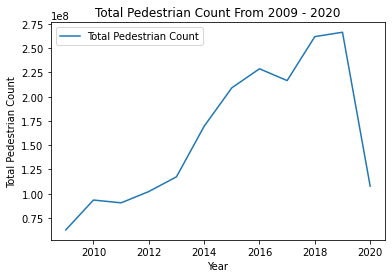

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# define the x and y columns
x = [x.Year for x in year_hourly_counts_df.select('Year').collect()]
y = [y.Total_Pedestrian_Counts for y in year_hourly_counts_df.select('Total_Pedestrian_Counts').collect()]
plt.plot(x,y)

# set the labels, titlte and legend
plt.ylabel('Total Pedestrian Count')
plt.xlabel('Year')
plt.title('Total Pedestrian Count From 2009 - 2020')
plt.legend(['Total Pedestrian Count'], loc='upper left')

# show the plot
plt.show()

Displaying the sensor ID, sensor description and average hourly count for the top-5 sensors with the highest average hourly pedestrian counts. The dataframe created compute the average hourly pedestrian count for each sensor and sort the average count from highest to lowest, while combining the sensor description from the sensor location data

In [12]:
# select only the two required columns
sensorid_hourly_counts_df = monthly_counts_df.select('Sensor_ID', "Hourly_Counts")

# group by sensor id and sum the hourly counts
sensorid_hourly_counts_df = sensorid_hourly_counts_df.groupby("Sensor_ID").agg(F.sum("Hourly_Counts").alias('Total_Hourly_Counts'))

# create the average hourly pedestrain counts
sensorid_hourly_counts_df = sensorid_hourly_counts_df.withColumn('Average Hourly Pedestrian Counts',round((sensorid_hourly_counts_df.Total_Hourly_Counts/24), 2))

# remove total hourly counts
sensorid_hourly_counts_df = sensorid_hourly_counts_df.drop('Total_Hourly_Counts')

# join the two tables
sensorid_desc_avg_df = sensorid_hourly_counts_df.join(sensors_df,['Sensor_ID'],how='inner')

# sort descending order of the average count
sensorid_desc_avg_df = sensorid_desc_avg_df.sort('Average Hourly Pedestrian Counts', ascending = False)

# only select the required columns and show the top5
sensorid_desc_avg_df = sensorid_desc_avg_df.select(col('Sensor_ID').alias('Sensor ID'),col('sensor_description').alias('Sensor Description'), 'Average Hourly Pedestrian Counts').show(5)

+---------+--------------------+--------------------------------+
|Sensor ID|  Sensor Description|Average Hourly Pedestrian Counts|
+---------+--------------------+--------------------------------+
|        4|    Town Hall (West)|                      5642652.54|
|        6|Flinders Street S...|                      4823159.08|
|        3|   Melbourne Central|                      4674128.29|
|        2|Bourke Street Mal...|                      4348132.83|
|        5|      Princes Bridge|                      4252023.88|
+---------+--------------------+--------------------------------+
only showing top 5 rows



3. For the period starting from 2019-07-01 to 2019-07-28 (inclusive), get the breakdown of total daily pedestrian counts with the subtotal of the weekly counts. 

In [13]:
# create a UDF to convert the Mondays, Tuesdays ... to 1,2....  
def weekday(s):
    if s=='Monday':
        return '1'
    elif s=='Tuesday':
        return '2'
    elif s=='Wednesday':
        return '3'
    elif s=='Thursday':
        return '4'
    elif s=='Friday':
        return '5'
    elif s=='Saturday':
        return '6'
    else:
        return '7'

weekday_udf = udf(weekday,StringType())

# filter so that only values from 2019-07-01 to 2019-07-28 is taken
july_counts = monthly_counts_df.filter((monthly_counts_df['Year'] == 2019) & (monthly_counts_df['Month'] == 'July') & (monthly_counts_df['Mdate'] <= 28))

# Select Week of the year, day of the week and the hourly counts for those values
week_day_count_df = july_counts.select(weekofyear(july_counts.Date_Time).alias('Week'), weekday_udf(july_counts.Day).alias('Days Of Week'), 'Hourly_counts')

# get possible combinations of grouping columns and sum the hourly counts
week_day_count_df = week_day_count_df.cube(week_day_count_df['Week'], week_day_count_df['Days Of Week']).agg(F.sum("Hourly_Counts").alias('Total_Hourly_Counts'))

# sort ascending by week and day of week
week_day_count_df = week_day_count_df.sort('Week','Days Of Week')

# remove week null values in week
week_day_count_df = week_day_count_df.filter(week_day_count_df.Week.isNotNull())

# replace the nulls in Day Of Week to Subtotal
week_day_count_df = week_day_count_df.fillna({'Days Of Week':'Subtotal'}).show(50)


+----+------------+-------------------+
|Week|Days Of Week|Total_Hourly_Counts|
+----+------------+-------------------+
|  27|    Subtotal|            5179414|
|  27|           1|             681065|
|  27|           2|             703669|
|  27|           3|             755056|
|  27|           4|             792842|
|  27|           5|             938219|
|  27|           6|             778021|
|  27|           7|             530542|
|  28|    Subtotal|            4877306|
|  28|           1|             780253|
|  28|           2|             777528|
|  28|           3|             751076|
|  28|           4|             728401|
|  28|           5|             775136|
|  28|           6|             605764|
|  28|           7|             459148|
|  29|    Subtotal|            5011023|
|  29|           1|             668542|
|  29|           2|             697076|
|  29|           3|             707474|
|  29|           4|             755984|
|  29|           5|             902692|


4. Finding all days when the sensor 4 exhibits the trend as below, in which the pedestrian count increases between 12:00 and 14:00, then decreases between 14:00 and 19:00, increases again between 19:00 and 21:00, and finally decreases until 23:00. 

In [14]:
from pyspark.sql.window import Window

# data to be matched in the dataset
sample_df = spark.createDataFrame([
    (12, 'up', ),
    (13, 'up', ),
    (14, 'up', ),
    (15, 'down', ),
    (16, 'down', ),
    (17, 'down', ),
    (18, 'down', ),
    (19, 'up', ),
    (20, 'up', ),
    (21, 'up', ),
    (22, 'down', ),
    (23, 'down', ),
], ['Time', 'SampleTrend'])

# just get the values of sensor 4
only_sensor_four_df = monthly_counts_df.filter((monthly_counts_df['Sensor_ID'] == 4))

# get the previous value for each row and add it as the previous count column
window = Window.orderBy("Date_Time")
lagCol = lag(col("Hourly_Counts"), 1).over(window)
only_sensor_four_df = only_sensor_four_df.withColumn("Previous_Count", lagCol)

# create the trend column
trend = when(only_sensor_four_df["Previous_Count"]==only_sensor_four_df["Hourly_Counts"], "same").when(only_sensor_four_df["Previous_Count"]<only_sensor_four_df["Hourly_Counts"], "up").otherwise("down")
only_sensor_four_df = only_sensor_four_df.withColumn("Trend", trend)

# select only the required columns and join, this also filters all the results to be within the required ranged since inner join is used
only_sensor_four_df = only_sensor_four_df.select('Year', 'Month', 'Mdate', 'Time', 'Trend')
joined_df = only_sensor_four_df.join(sample_df,['Time'],how='inner').sort('Year', 'Month', 'Mdate', 'Time')

# create a function to compare Trend and sample trend
count_same_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

# group by and count the number of same trends
joined_df = joined_df.groupBy('Mdate', 'Month', 'Year').agg(count_same_cond(F.col('Trend') == F.col('SampleTrend')).alias('Number_of_Same_Trend'))

# get only those that have the same trend from 12:00 to 23:00 and show the date
joined_df = joined_df.filter(joined_df['Number_of_Same_Trend'] == 12).select('Year', 'Month', 'Mdate').show()


+----+--------+-----+
|Year|   Month|Mdate|
+----+--------+-----+
|2009|December|   31|
|2019|December|   24|
+----+--------+-----+



## 3 Performance comparison 
## 3.1 Performance comparison

**Task 1.2.3**

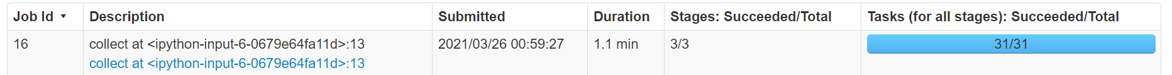
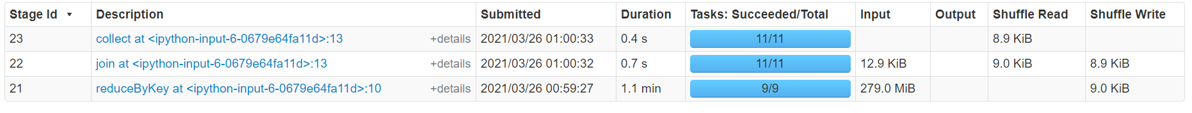
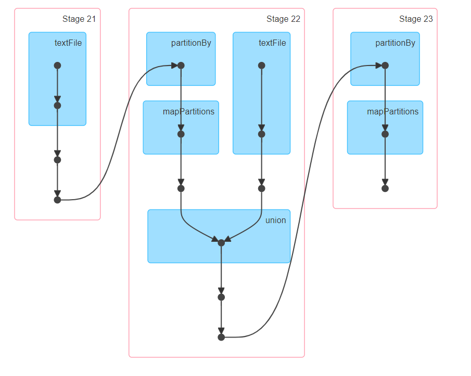

**Task 2.2.2**
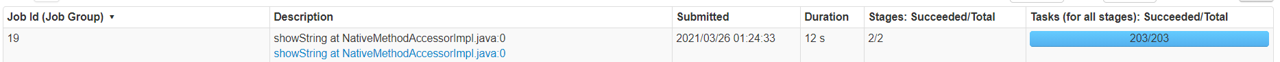
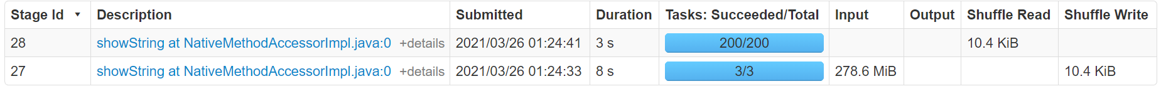
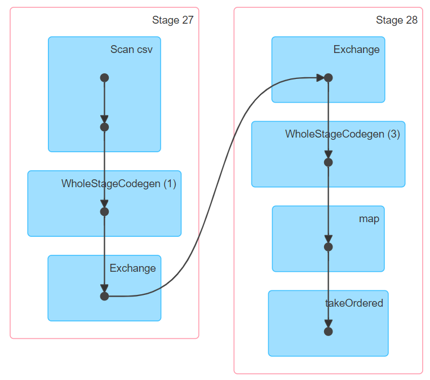

# Which one is faster? 

The Dataframe job is much faster than RDD job. This is because there are many aggreagation jobs within the tasks 1.2.3 and 2.2.2 which includes grouping by and joining the large datasets. Dataframes are able to perform faster when aggregating large data sets when compared to RDDs. Therefore, since dataframes are used in task 2.2.2, it is able to be completed much faster.

# Potential approaches that can improve this query performance

- A potential way to improve the performance is to use broadcast merge join instead of the default sort merge join that was used here. This is because the smaller table is very small, only consisting of a dozen rows. This makes it easy to be broadcast. This would help prevent the need to sort the big table which is very time-consuming in a sort merge join.
- Another potential way to improve performance is to use range partitioning for aggregation instead of hash partitioning. This is because the values have a very defined range which makes distribution more even. Thus, helping to speed up the process.